In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel, get_mixture
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier, sample_and_plot

import scipy

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt
import resource
import datetime
import time

2024-05-17 13:37:06.586632: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 13:37:06.638482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 13:37:06.638514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 13:37:06.639673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 13:37:06.648294: I tensorflow/core/platform/cpu_feature_guar

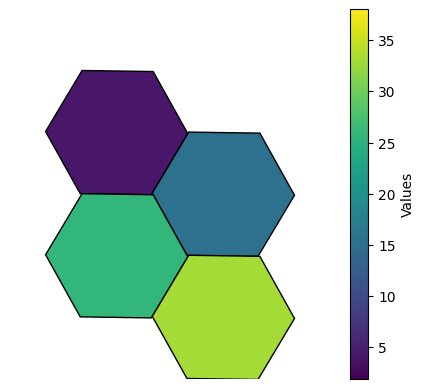

2024-05-17 13:37:12.612026: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-17 13:37:12.612067: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: p1cmp078.pax.tufts.edu
2024-05-17 13:37:12.612073: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: p1cmp078.pax.tufts.edu
2024-05-17 13:37:12.612178: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-05-17 13:37:12.612208: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-05-17 13:37:12.612214: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [2]:
# Distribution Settings
scale = 1
means = [5, 15, 25, 35]

normal_4 = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]
sample_and_plot(normal_4)

S=4
# Historical data as features
H=2
# Total timepoints in data
T = 1000

learning_rate = 0.05

train_dataset, val_dataset, test_dataset, (train_X_THS, train_y_TS), (val_X_THS, val_y_TS), (test_X_THS, test_y_TS) = example_datasets(H, T, dist_S=normal_4, return_numpy=True)

In [3]:
class LocSpecificMixWeights(keras.layers.Layer):
    """Dumb layer that just returns mixture weights
    Constrained to unit norm
    """
    def __init__(self, num_locations, num_components=2, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(name='shared_mix_weights',
            shape=(num_locations, num_components ),
            initializer="uniform",
            trainable=True,
        )
        
        self.softmax = keras.layers.Softmax(axis=1)

    def call(self, inputs):
        return self.softmax(self.w)

def build_mixture_normal(parameter_model, input_shape, scale=1, num_components=4, seed=360):
    num_features, num_locations = input_shape
    member_models = []
    for c in range(num_components):
        member_models.append(parameter_model(input_shape, seed=seed+1000*c))

    # Define layers
    inputs = keras.Input(shape=input_shape, name='mix_input')
    reshape_layer = keras.layers.Reshape(name='mix_reshape', target_shape=(-1,1))
    concat_layer = keras.layers.Concatenate(name='mix_concat',axis=-1)

    mixture_weight_layer = LocSpecificMixWeights(num_locations, name='mixture_weights', num_components=num_components)

    reshaped = [reshape_layer(member(inputs)) for member in member_models]
    concatted = concat_layer(reshaped)
    
    mixture_weights = mixture_weight_layer(inputs)

    mixture_distribution_layer = tfp.layers.DistributionLambda(lambda params: 
        tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=params[0]),
                                            components_distribution = tfp.distributions.Normal(loc=params[1], scale=scale, validate_args=True)))
    
    outputs = mixture_distribution_layer([mixture_weights, concatted])

    model = keras.Model(name='mixture_model', inputs=inputs, outputs=[outputs])

    return model, mixture_weights



In [13]:
    num_features, num_locations = (H,S)
    member_models = []
    for c in range(4):
        member_models.append(location_specific_linear((H,S), seed=360+1000*c))

    # Define layers
    inputs = keras.Input(shape=(H,S), name='mix_input')
    reshape_layer = keras.layers.Reshape(name='mix_reshape', target_shape=(-1,1))
    concat_layer = keras.layers.Concatenate(name='mix_concat',axis=-1)

    mixture_weight_layer = LocSpecificMixWeights(num_locations, name='mixture_weights', num_components=4)

    reshaped = [reshape_layer(member(inputs)) for member in member_models]
    concatted = concat_layer(reshaped)
    
    mixture_weights = mixture_weight_layer(inputs)

    mixture_distribution_layer = tfp.layers.DistributionLambda(lambda params: 
        tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=params[0]),
                                            components_distribution = tfp.distributions.Normal(loc=params[1], scale=scale, validate_args=True)))
    
    outputs = mixture_distribution_layer([mixture_weights, concatted])

    model = keras.Model(name='mixture_model', inputs=inputs, outputs=[outputs])

In [16]:
mixture_weights

<KerasTensor: shape=(4, 4) dtype=float32 (created by layer 'mixture_weights')>

In [12]:
model, mix_weights = build_mixture_normal(location_specific_linear, (H, S),scale=scale, num_components=4)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
mix_weights

<KerasTensor: shape=(4, 4) dtype=float32 (created by layer 'mixture_weights')>

In [7]:
# Set linear weights to 0
for index in [0, 2, 4, 6]:
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tf.zeros(variable.shape))
# set biases to true value
for index, bias in zip([1, 3, 5, 7], [5.0, 15.0, 25.0, 35.0]):
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tfp.math.softplus_inverse([bias]))
index = -1
variable = model.trainable_variables[index]
print(f'Name: {variable.name}')
print(f'Shape: {variable.shape}')

weights = tf.eye(4)

variable.assign(tf.math.log(weights+1e-13))

Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: shared_mix_weights:0
Shape: (4, 4)


<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[  0.      , -29.933605, -29.933605, -29.933605],
       [-29.933605,   0.      , -29.933605, -29.933605],
       [-29.933605, -29.933605,   0.      , -29.933605],
       [-29.933605, -29.933605, -29.933605,   0.      ]], dtype=float32)>

In [10]:
one_component = location_specific_linear((H, S), seed=360)
one_component(train_X_THS)

<tf.Tensor: shape=(600, 4), dtype=float32, numpy=
array([[0.34935072, 0.08884697, 0.01321701, 0.00416328],
       [0.23029381, 0.06361564, 0.04085373, 0.00252305],
       [0.42929456, 0.07015554, 0.01427219, 0.00596942],
       ...,
       [0.30742934, 0.03327321, 0.03738021, 0.00093028],
       [0.22660378, 0.11889522, 0.01434227, 0.01557586],
       [0.64175785, 0.07519296, 0.01920529, 0.00382214]], dtype=float32)>

In [7]:
param_value = 23.0
print(param_value)
variable = model.trainable_variables[5]
print(f'Name: {variable.name}')
print(f'Shape: {variable.shape}')
variable.assign(tfp.math.softplus_inverse([param_value]))

23.0
Name: linear_convolution/bias:0
Shape: (1,)


<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([23.], dtype=float32)>

In [24]:
num_score_func_samples=8

In [25]:
@tf.function(autograph=False)
def get_prob_decisions(model):
    sample_y_MBS = model.sample(num_score_func_samples)
    stopped_samples = tf.stop_gradient(sample_y_MBS)
    sample_log_probs_MBS = model.log_prob(stopped_samples)

    sample_decisions_MBS = tf.identity(sample_y_MBS)
    expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
    return sample_log_probs_MBS, sample_decisions_MBS,  expected_decisions_BS

@tf.function
def get_loss(y_batch, expected_decisions_BS):
    loss_B = keras.losses.mean_squared_error(y_batch, expected_decisions_BS)
    return loss_B

In [26]:
@tf.function
def train_step(model, x_batch, y_batch):
  with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
      mixture_model = model(x_batch, training=True)
      sample_log_probs_MBS, sample_decisions_MBS,  expected_decisions_BS = get_prob_decisions(mixture_model)
      loss_B = get_loss(y_batch, expected_decisions_BS)

  jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
  param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
  
  loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
  overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

  optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))
  return loss_B
     

In [11]:
logs = {}
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)
#callbacks.on_train_begin(logs=logs)
for epoch in range(1):
    #callbacks.on_epoch_begin(epoch, logs=logs)
    for batch, (x_batch, y_batch) in enumerate(train_dataset):
        #callbacks.on_batch_begin(batch, logs=logs)
        #callbacks.on_train_batch_begin(batch, logs=logs)
        
        tf.summary.trace_on(graph=True, profiler=True)
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
            mixture_model = model(x_batch, training=True)
            sample_log_probs_MBS, sample_decisions_MBS,  expected_decisions_BS = get_prob_decisions(mixture_model)
            loss_B = get_loss(y_batch, expected_decisions_BS)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))
        with writer.as_default():
            tf.summary.trace_export(
                name="my_func_trace",
                step=0,
                profiler_outdir=logdir)
        tf.summary.trace_off()
        #callbacks.on_test_batch_end(batch, logs=logs)
        #callbacks.on_batch_end(batch, logs=logs)
    #callbacks.on_epoch_end(epoch, logs=logs)
#callbacks.on_train_end(logs=logs)


2024-05-17 09:23:37.067637: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-05-17 09:23:37.067661: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-05-17 09:23:41.074704: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-05-17 09:23:41.088668: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [27]:
logs = {}
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = f'logs/func/{stamp}_samp{num_score_func_samples}' 
writer = tf.summary.create_file_writer(logdir)
#callbacks.on_train_begin(logs=logs)
for epoch in range(1):
    #callbacks.on_epoch_begin(epoch, logs=logs)
    for batch, (x_batch, y_batch) in enumerate(train_dataset):
        #callbacks.on_batch_begin(batch, logs=logs)
        #callbacks.on_train_batch_begin(batch, logs=logs)
        
        tf.summary.trace_on(graph=True, profiler=True)
        loss_B = train_step(model, x_batch, y_batch)
        with writer.as_default():
            tf.summary.trace_export(
                name="my_func_trace",
                step=0,
                profiler_outdir=logdir)
        tf.summary.trace_off()
        #callbacks.on_test_batch_end(batch, logs=logs)
        #callbacks.on_batch_end(batch, logs=logs)
    #callbacks.on_epoch_end(epoch, logs=logs)
#callbacks.on_train_end(logs=logs)


2024-05-17 09:42:24.722179: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-05-17 09:42:24.722219: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-05-17 09:42:38.045224: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/MixtureSameFamily_CONSTRUCTED_AT_mixture_model_distribution_lambda/sample/BatchBroadcastNormal/assert_positive/assert_less/Assert/AssertGuard/branch_executed/_264


In [22]:
tf.reduce_max(param_gradient_pBS[5])

<tf.Tensor: shape=(), dtype=float32, numpy=45.609947>

In [23]:
loss_B

<tf.Tensor: shape=(600,), dtype=float32, numpy=
array([114.49257 , 117.37792 , 134.83798 , 117.13356 , 137.0539  ,
       121.22895 , 131.36864 , 148.06226 , 139.75972 , 132.89978 ,
       117.53221 , 127.433   , 125.493256, 152.8707  , 124.846405,
       102.05618 , 152.83049 , 125.021866, 133.73601 , 139.80951 ,
       143.00539 , 141.79117 , 127.03581 , 114.07889 , 163.56137 ,
       134.8587  , 136.65953 , 135.99298 , 141.62054 , 159.63412 ,
       123.058426, 129.55087 , 110.77827 , 138.41034 , 121.452515,
       137.21036 , 151.86597 , 157.1213  , 151.14484 , 137.26418 ,
       119.44594 , 110.03151 , 130.72528 , 160.82129 , 154.18776 ,
       145.069   , 113.524414, 148.19516 , 124.72876 , 126.43051 ,
       157.13968 , 111.48842 , 137.79385 , 127.529724, 147.61624 ,
       139.31128 , 128.52065 , 121.4346  , 140.13387 , 126.75251 ,
       126.84385 , 141.40533 , 140.90671 , 128.80795 , 122.726425,
       133.84232 , 107.88482 , 129.74211 , 147.4369  , 109.972015,
       129.762